In [1]:
# Import 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
from geopy.geocoders import Nominatim
import time  # To handle rate-limiting by introducing pauses
from geopy.exc import GeocoderTimedOut


In [2]:
homeless_data = pd.read_csv('Daily shelter overnight occupancy.csv')

In [3]:
homeless_data.head()

,_id,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,...,OCCUPIED_BEDS,UNOCCUPIED_BEDS,UNAVAILABLE_BEDS,CAPACITY_ACTUAL_ROOM,CAPACITY_FUNDING_ROOM,OCCUPIED_ROOMS,UNOCCUPIED_ROOMS,UNAVAILABLE_ROOMS,OCCUPANCY_RATE_BEDS,OCCUPANCY_RATE_ROOMS
0,1,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,...,NaN,NaN,NaN,149.0,150.0,149.0,0.0,1.0,NaN,100.0
1,2,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,...,NaN,NaN,NaN,57.0,57.0,57.0,0.0,0.0,NaN,100.0
2,3,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1051.0,COSTI Reception Centre,100 Lippincott St,M5S 2P1,...,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,100.0,NaN
3,4,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,...,NaN,NaN,NaN,67.0,83.0,67.0,0.0,16.0,NaN,100.0
4,5,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,...,NaN,NaN,NaN,161.0,148.0,161.0,0.0,0.0,NaN,100.0


## Clean the Data!


In [4]:
homeless_data.columns

Index(['_id', 'OCCUPANCY_DATE', 'ORGANIZATION_ID', 'ORGANIZATION_NAME',
       'SHELTER_ID', 'SHELTER_GROUP', 'LOCATION_ID', 'LOCATION_NAME',
       'LOCATION_ADDRESS', 'LOCATION_POSTAL_CODE', 'LOCATION_CITY',
       'LOCATION_PROVINCE', 'PROGRAM_ID', 'PROGRAM_NAME', 'SECTOR',
       'PROGRAM_MODEL', 'OVERNIGHT_SERVICE_TYPE', 'PROGRAM_AREA',
       'SERVICE_USER_COUNT', 'CAPACITY_TYPE', 'CAPACITY_ACTUAL_BED',
       'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS',
       'UNAVAILABLE_BEDS', 'CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM',
       'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS',
       'OCCUPANCY_RATE_BEDS', 'OCCUPANCY_RATE_ROOMS'],
      dtype='object')

Drop the Columns: 'CAPACITY_TYPE', 'CAPACITY_ACTUAL_BED',
       'CAPACITY_FUNDING_BED', 'OCCUPIED_BEDS', 'UNOCCUPIED_BEDS',
       'UNAVAILABLE_BEDS', 'CAPACITY_ACTUAL_ROOM', 'CAPACITY_FUNDING_ROOM',
       'OCCUPIED_ROOMS', 'UNOCCUPIED_ROOMS', 'UNAVAILABLE_ROOMS',
       'OCCUPANCY_RATE_BEDS', 'OCCUPANCY_RATE_ROOMS'
       
These do not provide further or relevant information.

In [5]:
homeless_data.drop(homeless_data.columns[-13:] ,axis = 1, inplace=True)

In [6]:
homeless_data.head()

,_id,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,LOCATION_PROVINCE,PROGRAM_ID,PROGRAM_NAME,SECTOR,PROGRAM_MODEL,OVERNIGHT_SERVICE_TYPE,PROGRAM_AREA,SERVICE_USER_COUNT
0,1,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,Toronto,ON,16892,COSTI - Hotel Program - Dixon (Refugee Families),Families,Emergency,Motel/Hotel Shelter,Temporary Refugee Response,650
1,2,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1320.0,COSTI Hotel Program Dixon,640 Dixon Rd.,M9W 1J1,Toronto,ON,16891,COSTI - Hotel Program - Dixon (Refugee Singles),Mixed Adult,Emergency,Motel/Hotel Shelter,Temporary Refugee Response,113
2,3,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1051.0,COSTI Reception Centre,100 Lippincott St,M5S 2P1,Toronto,ON,12251,COSTI Reception Centre CITY Program,Mixed Adult,Emergency,Shelter,Base Program - Refugee,8
3,4,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,North York,ON,15372,COSTI Uptown Hotel COVID-19 - Family Program,Families,Emergency,Motel/Hotel Shelter,Temporary Programs,203
4,5,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,North York,ON,13751,COSTI Uptown Hotel Family Program,Families,Emergency,Motel/Hotel Shelter,Temporary Refugee Response,508


It can be noticed from the PROGRAM_AREA column contains information such as Refugee Response programs. These are not the individuals that we are looking to model. Refugee programs do appear to usually be coorelated with OVERNIGHT_SERVICE_TYPE of Motel/Hotel Shelter; however, they could also be housed in basic Shelters as well. 

In [7]:
# Inspect the Columns to see all the unique datas
print(homeless_data['OVERNIGHT_SERVICE_TYPE'].unique())
print(homeless_data['PROGRAM_AREA'].unique())

['Motel/Hotel Shelter' 'Shelter' 'Warming Centre'
 'Isolation/Recovery Site' '24-Hour Respite Site'
 "24-Hour Women's Drop-in" 'Alternative Space Protocol'
 'Top Bunk Contingency Space']
['Temporary Refugee Response' 'Base Program - Refugee'
 'Temporary Programs' 'Base Shelter and Overnight Services System'
 'Winter Programs']


We will first try filtering by the PROGRAM_AREA column using the string Refugee.

In [8]:
# Remove rows where 'PROGRAM_AREA' contains the string 'Refugee'
homeless_data = homeless_data[~homeless_data['PROGRAM_AREA'].str.contains('Refugee', na=False)]

# Check the result
print(homeless_data['PROGRAM_AREA'].unique())
homeless_data.head()

['Temporary Programs' 'Base Shelter and Overnight Services System'
 'Winter Programs']


,_id,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,LOCATION_PROVINCE,PROGRAM_ID,PROGRAM_NAME,SECTOR,PROGRAM_MODEL,OVERNIGHT_SERVICE_TYPE,PROGRAM_AREA,SERVICE_USER_COUNT
3,4,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,North York,ON,15372,COSTI Uptown Hotel COVID-19 - Family Program,Families,Emergency,Motel/Hotel Shelter,Temporary Programs,203
5,6,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1160.0,CONC Etobicoke Hotel Program,445 Rexdale Blvd,M9W 6P8,Etobicoke,ON,16111,CONC Etobicoke Hotel Program - Mixed Adult,Mixed Adult,Emergency,Motel/Hotel Shelter,Temporary Programs,152
6,7,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1172.0,CONC West End Hotel Program,14 Roncesvalles Ave,M6R 2K3,Toronto,ON,15711,CONC Men's Hotel Program,Men,Emergency,Motel/Hotel Shelter,Temporary Programs,39
7,8,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1029.0,CONC Men's Shelter Lansdowne Ave,973 Lansdowne Ave,M6H 3Z5,Toronto,ON,12011,Christie Ossington Men's Hostel,Men,Emergency,Shelter,Base Shelter and Overnight Services System,42
8,9,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1102.0,CONC Men's Shelter Bloor St W,850 Bloor St W,M6G 1M2,Toronto,ON,13611,Christie Ossington Men's Hostel South,Men,Emergency,Shelter,Base Shelter and Overnight Services System,30


#### Missing Values!

In [9]:
# Create a Series dataframe that shows the missing value counts for each columns

homeless_data_missing = homeless_data.isnull().sum().to_frame(name = 'count')

# View DataFrame
homeless_data_missing

,count
_id,0
OCCUPANCY_DATE,0
ORGANIZATION_ID,0
ORGANIZATION_NAME,0
SHELTER_ID,0
SHELTER_GROUP,0
LOCATION_ID,0
LOCATION_NAME,331
LOCATION_ADDRESS,1624
LOCATION_POSTAL_CODE,1624


In [10]:
homeless_data['LOCATION_ID'].unique()

array([1114., 1160., 1172., 1029., 1102., 1541., 1070., 1561., 1009.,
       1194., 1065., 1066., 1067., 1011., 1360., 1069., 1163., 1151.,
       1154., 1008., 1190., 1004., 1123., 1103., 1124., 1005., 1028.,
       1026., 1027., 1149., 1125., 1128., 1176., 1015., 1020., 1460.,
       1025., 1024., 1155., 1053., 1054., 1099., 1081., 1007., 1193.,
       1055., 1130., 1152., 1521., 1187., 1022., 1021., 1168., 1108.,
       1150., 1195., 1220., 1153., 1179., 1200., 1031., 1019., 1080.,
       1118., 1002., 1013., 1018., 1500., 1104., 1050., 1049., 1048.,
       1039., 1148., 1192., 1045., 1180., 1036., 1189., 1037., 1166.,
       1057., 1126., 1146., 1300., 1014., 1041., 1115., 1280., 1001.,
       1096., 1101., 1062., 1129., 1064., 1147., 1440., 1078.])

In [11]:
# Print rows with missing values in any column
missing_data_rows = homeless_data[homeless_data.isnull().any(axis=1)]

# Display the rows with missing values
print(missing_data_rows['LOCATION_ID'].unique())
print(missing_data_rows['SHELTER_GROUP'].unique())
print(missing_data_rows['LOCATION_NAME'].unique())


[1163. 1187. 1280. 1440.]
['SSHA Etobicoke Hotel Program' 'Friends of Ruby' "Nellie's"
 'Birkdale Residence']
['TSSS Etobicoke Hotel Program' 'Friends of Ruby' nan
 'CONC - Warming Centre - Cecil']


From this we can interpret that there are only 4 locations with missing data. We can then manually assign a dataframe for the missing values, so that we do not need to drop crucial data. 

In [12]:
# Define a mapping of shelter group names to their corresponding address details
address_mapping = {
    'SSHA Etobicoke Hotel Program': {
        'LOCATION_ADDRESS': '2180 Islington Ave',
        'LOCATION_NAME': 'TSSS Etobicoke Hotel Program',
        'LOCATION_POSTAL_CODE': 'M9P 3P1',
        'LOCATION_CITY': 'Toronto',
        'LOCATION_PROVINCE': 'ON'
    },
    'Friends of Ruby': {
        'LOCATION_ADDRESS': '489 Queen St E',
        'LOCATION_NAME': 'Friends of Ruby',
        'LOCATION_POSTAL_CODE': 'M5A 1V1',
        'LOCATION_CITY': 'Toronto',
        'LOCATION_PROVINCE': 'ON'
    },
    "Nellie's": {
        'LOCATION_ADDRESS': '58 Cecil St',
        'LOCATION_NAME': "Nellie's",
        'LOCATION_POSTAL_CODE': 'M5T 1N6',
        'LOCATION_CITY': 'Toronto',
        'LOCATION_PROVINCE': 'ON'
    },
    "Birkdale Residence": {
        'LOCATION_ADDRESS': '1229 Ellesmere Rd',
        'LOCATION_NAME': 'Birkdale Residence',
        'LOCATION_POSTAL_CODE': 'M1P 4V8',
        'LOCATION_CITY': 'Toronto',
        'LOCATION_PROVINCE': 'ON'
    }
   
}


# Define the function to apply this mapping
def fill_address(row):
    shelter_group = row['SHELTER_GROUP']
    if shelter_group in address_mapping:
        return address_mapping[shelter_group]
    else:
        return {
            'LOCATION_ADDRESS': None,
            'LOCATION_NAME': None,
            'LOCATION_POSTAL_CODE': None,
            'LOCATION_CITY': None,
            'LOCATION_PROVINCE': None
        }

# Identify rows with missing address information
address_filled = homeless_data[homeless_data['LOCATION_ADDRESS'].isnull()]

# Apply the mapping to fill missing address columns
filled_address_data = address_filled.apply(fill_address, axis=1, result_type="expand")

# Update the original dataframe with the filled address data
homeless_data.loc[homeless_data['LOCATION_ADDRESS'].isnull(), ['LOCATION_ADDRESS', 'LOCATION_NAME', 'LOCATION_POSTAL_CODE', 'LOCATION_CITY', 'LOCATION_PROVINCE']] = filled_address_data[['LOCATION_ADDRESS', 'LOCATION_NAME', 'LOCATION_POSTAL_CODE', 'LOCATION_CITY', 'LOCATION_PROVINCE']].values

# Check the updated data (for example, print out the first few rows)
print(homeless_data[['SHELTER_GROUP', 'LOCATION_ADDRESS', 'LOCATION_CITY']].head())

                     SHELTER_GROUP     LOCATION_ADDRESS LOCATION_CITY
3           COSTI Reception Centre      55 Hallcrown Pl    North York
5  Christie Ossington Men's Hostel     445 Rexdale Blvd     Etobicoke
6  Christie Ossington Men's Hostel  14 Roncesvalles Ave       Toronto
7  Christie Ossington Men's Hostel    973 Lansdowne Ave       Toronto
8  Christie Ossington Men's Hostel       850 Bloor St W       Toronto


In [13]:
# Create a Series dataframe that shows the missing value counts for each columns

homeless_data_missing = homeless_data.isnull().sum().to_frame(name = 'count')

# View DataFrame
homeless_data_missing

,count
_id,0
OCCUPANCY_DATE,0
ORGANIZATION_ID,0
ORGANIZATION_NAME,0
SHELTER_ID,0
SHELTER_GROUP,0
LOCATION_ID,0
LOCATION_NAME,0
LOCATION_ADDRESS,0
LOCATION_POSTAL_CODE,0


For missing LOCATION_CITY and LOCATION_PROVINCE, we can fill in 'Toronto' and 'Ontario'. 

In [14]:
# Fill missing values in 'LOCATION_CITY' and 'LOCATION_PROVINCE'
homeless_data['LOCATION_CITY'] = homeless_data['LOCATION_CITY'].fillna('Toronto')
homeless_data['LOCATION_PROVINCE'] = homeless_data['LOCATION_PROVINCE'].fillna('Ontario')

In [15]:
# Create a Series dataframe that shows the missing value counts for each columns

homeless_data_missing = homeless_data.isnull().sum().to_frame(name = 'count')

# View DataFrame
homeless_data_missing

,count
_id,0
OCCUPANCY_DATE,0
ORGANIZATION_ID,0
ORGANIZATION_NAME,0
SHELTER_ID,0
SHELTER_GROUP,0
LOCATION_ID,0
LOCATION_NAME,0
LOCATION_ADDRESS,0
LOCATION_POSTAL_CODE,0


Display the cleaned homeless data.

In [16]:
homeless_data.head()

,_id,OCCUPANCY_DATE,ORGANIZATION_ID,ORGANIZATION_NAME,SHELTER_ID,SHELTER_GROUP,LOCATION_ID,LOCATION_NAME,LOCATION_ADDRESS,LOCATION_POSTAL_CODE,LOCATION_CITY,LOCATION_PROVINCE,PROGRAM_ID,PROGRAM_NAME,SECTOR,PROGRAM_MODEL,OVERNIGHT_SERVICE_TYPE,PROGRAM_AREA,SERVICE_USER_COUNT
3,4,2024-01-01,24,COSTI Immigrant Services,40,COSTI Reception Centre,1114.0,COSTI Uptown Hotel Program,55 Hallcrown Pl,M2J 4R1,North York,ON,15372,COSTI Uptown Hotel COVID-19 - Family Program,Families,Emergency,Motel/Hotel Shelter,Temporary Programs,203
5,6,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1160.0,CONC Etobicoke Hotel Program,445 Rexdale Blvd,M9W 6P8,Etobicoke,ON,16111,CONC Etobicoke Hotel Program - Mixed Adult,Mixed Adult,Emergency,Motel/Hotel Shelter,Temporary Programs,152
6,7,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1172.0,CONC West End Hotel Program,14 Roncesvalles Ave,M6R 2K3,Toronto,ON,15711,CONC Men's Hotel Program,Men,Emergency,Motel/Hotel Shelter,Temporary Programs,39
7,8,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1029.0,CONC Men's Shelter Lansdowne Ave,973 Lansdowne Ave,M6H 3Z5,Toronto,ON,12011,Christie Ossington Men's Hostel,Men,Emergency,Shelter,Base Shelter and Overnight Services System,42
8,9,2024-01-01,14,Christie Ossington Neighbourhood Centre,22,Christie Ossington Men's Hostel,1102.0,CONC Men's Shelter Bloor St W,850 Bloor St W,M6G 1M2,Toronto,ON,13611,Christie Ossington Men's Hostel South,Men,Emergency,Shelter,Base Shelter and Overnight Services System,30


## Exploratory Data Analysis

In [17]:
homeless_data.dtypes

_id                         int64
OCCUPANCY_DATE             object
ORGANIZATION_ID             int64
ORGANIZATION_NAME          object
SHELTER_ID                  int64
SHELTER_GROUP              object
LOCATION_ID               float64
LOCATION_NAME              object
LOCATION_ADDRESS           object
LOCATION_POSTAL_CODE       object
LOCATION_CITY              object
LOCATION_PROVINCE          object
PROGRAM_ID                  int64
PROGRAM_NAME               object
SECTOR                     object
PROGRAM_MODEL              object
OVERNIGHT_SERVICE_TYPE     object
PROGRAM_AREA               object
SERVICE_USER_COUNT          int64
dtype: object

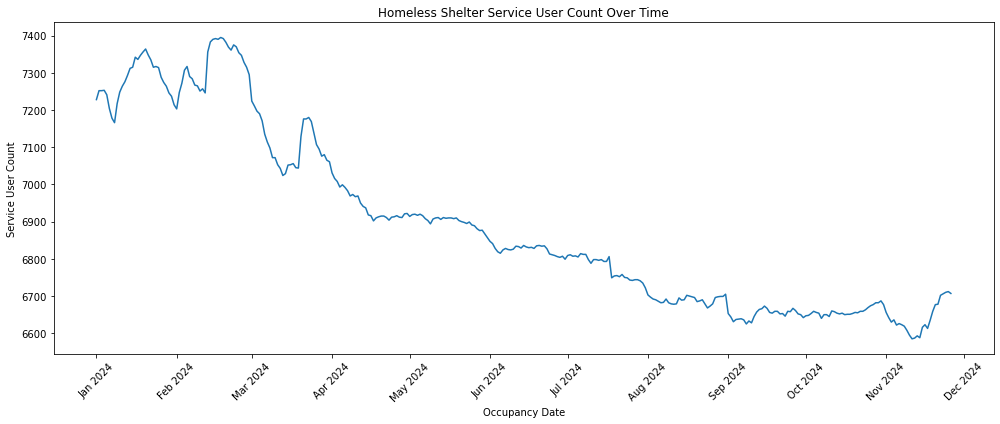

In [18]:
# Convert OCCUPANCY_DATE to datetime format
homeless_data['OCCUPANCY_DATE'] = pd.to_datetime(homeless_data['OCCUPANCY_DATE'])

# Group by 'OCCUPANCY_DATE' and sum 'SERVICE_USER_COUNT'
grouped_data = homeless_data.groupby('OCCUPANCY_DATE')['SERVICE_USER_COUNT'].sum().reset_index()

# Create the line plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=grouped_data, x='OCCUPANCY_DATE', y='SERVICE_USER_COUNT')

# Add labels and title
plt.xlabel('Occupancy Date')
plt.ylabel('Service User Count')
plt.title('Homeless Shelter Service User Count Over Time')

# Format the x-axis to show months and years
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks at monthly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format ticks as 'Month Year'

# Rotate the date labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Show the plot
plt.show()

# Folium Plot of Shelters

In [22]:
shelter_addresses = homeless_data['LOCATION_ADDRESS'].unique().tolist()
print(shelter_addresses[:5])

['55 Hallcrown Pl', '445 Rexdale Blvd', '14 Roncesvalles Ave', '973 Lansdowne Ave', '850 Bloor St W']


In [27]:
# Initialize geolocator
geolocator = Nominatim(user_agent="homeless_shelters_geocode")

# Function to geocode an address with retry mechanism

# Create geolocator with a longer timeout
geolocator = Nominatim(user_agent="homeless_shelter_locator", timeout=10)  # Set timeout to 10 seconds

def geocode_address(address, retries=5, delay=1):
    for attempt in range(retries):
        try:
            # Geocode with extra location constraints: restrict search to Toronto, Canada
            location = geolocator.geocode(address + ", Toronto, Canada")
            if location:
                return location.latitude, location.longitude
            else:
                return None, None  # If geocoding fails
        except GeocoderTimedOut:
            print(f"Timeout error for address: {address}. Retrying...")
            time.sleep(delay)  # Wait before retrying
        except Exception as e:
            print(f"Error geocoding {address}: {e}")
            return None, None  # For any other error
    return None, None  # Return None if retries exhausted


In [29]:
coordinates = []
failed_addresses = []  # To keep track of addresses that failed

for address in shelter_addresses:
    lat, lon = geocode_address(address)
    if lat is None and lon is None:
        failed_addresses.append(address)  # Add failed address to the list
    coordinates.append((address, lat, lon)) # Store address with coordinates (or None)

print(coordinates[:5])  # Check the first few results to confirm the geocoding is correct

[('55 Hallcrown Pl', 43.7692665, -79.322408630854), ('445 Rexdale Blvd', 43.71604835, -79.59398958554878), ('14 Roncesvalles Ave', 43.63901885, -79.4465142944708), ('973 Lansdowne Ave', 43.6660985, -79.44601095079787), ('850 Bloor St W', 43.66244259375, -79.42414367500001)]


In [30]:
# Print out failed addresses (if any)
if failed_addresses:
    print("Failed geocoding the following addresses:")
    for failed in failed_addresses:
        print(failed)
if len(failed_addresses) == False:
    print("No failed addresses!")

No failed addresses!


With the list of coordinates that relate to the addresses of each homeless shelter, *coordinates*, a folium map can be created with these coordinates plotted as markers.

In [31]:
# Create a Folium map centered around Toronto's approximate coordinates
map_center = [43.67, -79.42]  # Centering on Toronto
homeless_shelter_map = folium.Map(location=map_center, zoom_start=12)

# Loop through coordinates and add a red marker for each
for address, lat, lon in coordinates:
    if lat is not None and lon is not None:
        # Create a red marker
        folium.Marker(
            location=[lat, lon],
            popup=address,  # Popup with the address
            icon=folium.Icon(color='red', icon='info-sign', icon_color='white', prefix='fa')  # Red marker with white icon
        ).add_to(homeless_shelter_map)

# Save map to an HTML file to view
homeless_shelter_map.save("homeless_shelters_map.html")

# If you want to view the map inline in a Jupyter Notebook, you can use:
homeless_shelter_map

Jason's Shitty Code

In [32]:
# Import 3rd party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium



# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

In [35]:
#import the bike theft dataset as a dataframe
bike_data = pd.read_csv('Bicycle_Thefts_Open_Data.csv')

In [36]:
bike_data['REPORT_DATE'] = pd.to_datetime(bike_data['REPORT_DATE'])

bike_data['year'] = bike_data['REPORT_DATE'].dt.year
bike_data['month'] = bike_data['REPORT_DATE'].dt.month
bike_data['day_of_the_week'] = bike_data['REPORT_DATE'].dt.day_of_week

In [37]:
map_center = [43.67, -79.42]
m = folium.Map(location=map_center, zoom_start=12)
map_center = [43.67, -79.42]
# Create heatmap
heat_data = [[row['LAT_WGS84'], row['LONG_WGS84']] for _, row in bike_data.iterrows()]
HeatMap(heat_data).add_to(m)

# Save or display the map
m.save("bike_theft_heatmap.html")
m

NameError: name 'HeatMap' is not defined